In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import h5py
import cv2
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.image
from skimage.transform import resize
from sklearn.model_selection import train_test_split
import keras
from keras.metrics import Precision, Recall
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import LabelEncoder
from keras.models import load_model
from keras.losses import binary_crossentropy
from keras import backend as K
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import  BatchNormalization
import numpy as np

In [ ]:
images=np.load('/content/drive/MyDrive/Numpy Figshare Data/Copy of images.npy')

In [ ]:
labels=np.load('/content/drive/MyDrive/Numpy Figshare Data/Copy of labels.npy')

In [ ]:
masks=np.load('/content/drive/MyDrive/Numpy Figshare Data/Copy of masks1.npy')

In [ ]:
x_train, x_test, y_train, y_test= train_test_split (images,masks,test_size=0.2, shuffle= True)
x_train.shape

(2451, 128, 128, 1)

In [ ]:
x_train= np.append( x_train, [ np.fliplr(x) for x in  x_train], axis=0 )
y_train = np.append( y_train, [ np.fliplr(y) for y in  y_train], axis=0 )

In [ ]:

train_datagen = ImageDataGenerator(brightness_range=(0.9,1.1),
                                   zoom_range=[.9,1.1],
                                   fill_mode='nearest')
val_datagen = ImageDataGenerator()

In [ ]:
def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score
def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
def dice_coeff(y_true, y_pred):
    smooth = 1e-6
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())


In [ ]:
def squeeze_excite_block(input_tensor, ratio=16):
    squeeze = GlobalAveragePooling2D()(input_tensor)

    excitation = Dense(units=int(input_tensor.shape[-1] / ratio), activation='relu')(squeeze)
    excitation = Dense(units=input_tensor.shape[-1], activation='sigmoid')(excitation)
    excitation = Reshape((1, 1, input_tensor.shape[-1]))(excitation)

    scaled_input = Multiply()([input_tensor, excitation])

    return scaled_input

In [ ]:
#UNET Single Conv and Transpose
from keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Dropout, Input, BatchNormalization
from keras import optimizers
from keras.models import Model
from keras.layers import Reshape, Multiply

IMG_DIM = (128,128,1)

def conv2d_block( input_tensor, n_filters, kernel_size = (3,3), name="contraction"):
  "Add 2 conv layer"
  x = Conv2D(filters=n_filters, kernel_size=kernel_size, kernel_initializer='he_normal',
             padding='same',activation="relu", name=name+'_1')(input_tensor)
  x = squeeze_excite_block(x)
  return x


inp = Input( shape=IMG_DIM )

d = conv2d_block( inp, 32, name="contraction")
p = MaxPooling2D( pool_size=(2,2), strides=(2,2))(d)
p = BatchNormalization(momentum=0.8)(p)
p = Dropout(0.2)(p)

d1 = conv2d_block( p, 64, name="contraction_1")
p1 = MaxPooling2D( pool_size=(2,2), strides=(2,2))(d1)
p1 = BatchNormalization(momentum=0.8)(p1)
p1 = Dropout(0.2)(p1)

d2 = conv2d_block( p1, 128, name="contraction_2_1" )
p2 = MaxPooling2D(pool_size=(2,2), strides=(2,2) )(d2)
p2 = BatchNormalization(momentum=0.8)(p2)
p2 = Dropout(0.2)(p2)

d3 = conv2d_block( p2, 256, name="contraction_3_1")
p3 = MaxPooling2D(pool_size=(2,2), strides=(2,2) )(d3)
p3 = BatchNormalization(momentum=0.8)(p3)
p3 = Dropout(0.2)(p3)

d4 = conv2d_block(p3,512, name="contraction_4_1")
p4 = MaxPooling2D(pool_size=(2,2), strides=(2,2) )(d4)
p4 = BatchNormalization(momentum=0.8)(p4)
p4 = Dropout(0.2)(p4)

d5 = conv2d_block(p4,512, name="contraction_5_1")

u1 = Conv2DTranspose(512, (3, 3), strides = (2, 2), padding = 'same')(d5)
u1 = concatenate([u1,d4])
u1 = Dropout(0.2)(u1)
c1 = conv2d_block(u1, 512, name="expansion_1")

u2 = Conv2DTranspose(256, (3, 3), strides = (2, 2), padding = 'same')(c1)
u2 = concatenate([u2,d3])
u2 = Dropout(0.2)(u2)
c2 = conv2d_block(u2, 256, name="expansion_2")

u3 = Conv2DTranspose(128, (3, 3), strides = (2, 2), padding = 'same')(c2)
u3 = concatenate([u3,d2])
u3 = Dropout(0.2)(u3)
c3 = conv2d_block(u3, 128, name="expansion_3")

u4 = Conv2DTranspose(64, (3, 3), strides = (2, 2), padding = 'same')(c3)
u4 = concatenate([u4,d1])
u4 = Dropout(0.2)(u4)
c4 = conv2d_block(u4,64, name="expansion_4")

u5 = Conv2DTranspose(32, (3, 3), strides = (2, 2), padding = 'same')(c4)
u5 = concatenate([u5,d])
u5 = Dropout(0.2)(u5)
c5 = conv2d_block(u5,32, name="expansion_5")

out = Conv2D(1, (1,1), name="output", activation='sigmoid')(c5)

unet = Model( inp, out )
unet.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 contraction_1 (Conv2D)      (None, 128, 128, 32)         320       ['input_4[0][0]']             
                                                                                                  
 global_average_pooling2d_3  (None, 32)                   0         ['contraction_1[0][0]']       
 1 (GlobalAveragePooling2D)                                                                       
                                                                                                  
 dense_62 (Dense)            (None, 2)                    66        ['global_average_pooling

In [ ]:
unet.compile(optimizer=optimizers.Adam(learning_rate=1e-3),
             loss=bce_dice_loss, metrics=['accuracy',dice_coeff, specificity])

In [ ]:
model_checkpoint  = ModelCheckpoint('model_best_checkpoint.h5', save_best_only=True,
                                    monitor='val_loss', mode='min', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min')
reduceLR = ReduceLROnPlateau(patience=2, verbose=2, monitor='val_loss',min_lr=0.000001, mode='min')

callback_list = [early_stopping, reduceLR, model_checkpoint]

In [ ]:
train_generator = train_datagen.flow(x_train, y_train, batch_size=32)
val_generator = val_datagen.flow(x_test, y_test, batch_size=32)

In [ ]:
hist = unet.fit(train_generator, validation_data=val_generator,epochs=50,batch_size=32,callbacks=callback_list[1])

Epoch 1/50
154/154 [==============================] - 43s 190ms/step - loss: 2.2027 - accuracy: 0.9587 - dice_coeff: 0.1154 - specificity: 0.9812 - val_loss: 1.1435 - val_accuracy: 0.9708 - val_dice_coeff: 0.1733 - val_specificity: 0.9937 - lr: 0.0010
Epoch 2/50
154/154 [==============================] - 29s 186ms/step - loss: 0.8238 - accuracy: 0.9711 - dice_coeff: 0.3707 - specificity: 0.9901 - val_loss: 0.7125 - val_accuracy: 0.9759 - val_dice_coeff: 0.4011 - val_specificity: 0.9962 - lr: 0.0010
Epoch 3/50
154/154 [==============================] - 29s 186ms/step - loss: 0.6099 - accuracy: 0.9757 - dice_coeff: 0.4816 - specificity: 0.9934 - val_loss: 0.5757 - val_accuracy: 0.9774 - val_dice_coeff: 0.4991 - val_specificity: 0.9961 - lr: 0.0010
Epoch 4/50
154/154 [==============================] - 29s 187ms/step - loss: 0.5346 - accuracy: 0.9769 - dice_coeff: 0.5386 - specificity: 0.9935 - val_loss: 0.6130 - val_accuracy: 0.9756 - val_dice_coeff: 0.4962 - val_specificity: 0.9931 - lr:

In [ ]:
hist_array = np.array([hist.history[key] for key in hist.history])

np.save('history.npy', hist_array)

20/20 [==============================] - 1s 43ms/step


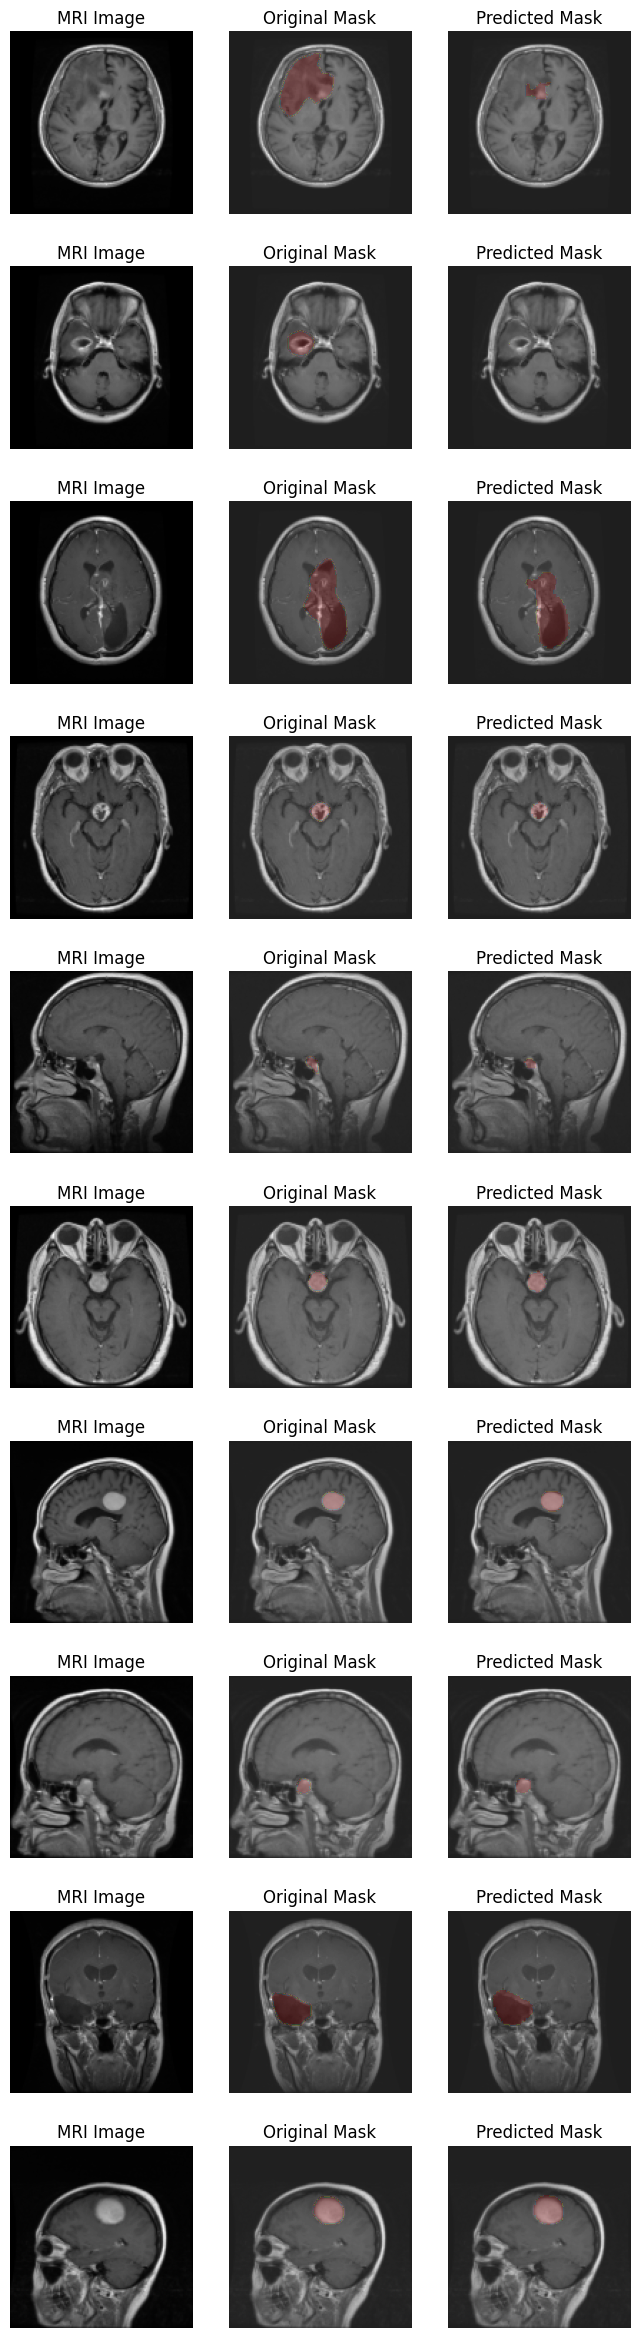

In [ ]:
THRESHOLD = 0.2
predicted_mask = (unet.predict(x_test)>THRESHOLD)*1

plt.figure(figsize=(8,30))
i=1;total=10
temp = np.ones_like(y_test[0] )
for idx in np.random.randint(0,high=x_test.shape[0],size=total):
    plt.subplot(total,3,i);i+=1
    plt.imshow( x_test[idx], cmap='gray' )
    plt.title("MRI Image");plt.axis('off')

    plt.subplot(total,3,i);i+=1
    plt.imshow( x_test[idx], cmap='gray' )
    plt.imshow( temp - y_test[idx], alpha=0.2, cmap='Set1' )
    plt.title("Original Mask");plt.axis('off')

    plt.subplot(total,3,i);i+=1
    plt.imshow( x_test[idx], cmap='gray' )
    plt.imshow( temp - predicted_mask[idx],  alpha=0.2, cmap='Set1' )
    plt.title("Predicted Mask");plt.axis('off')

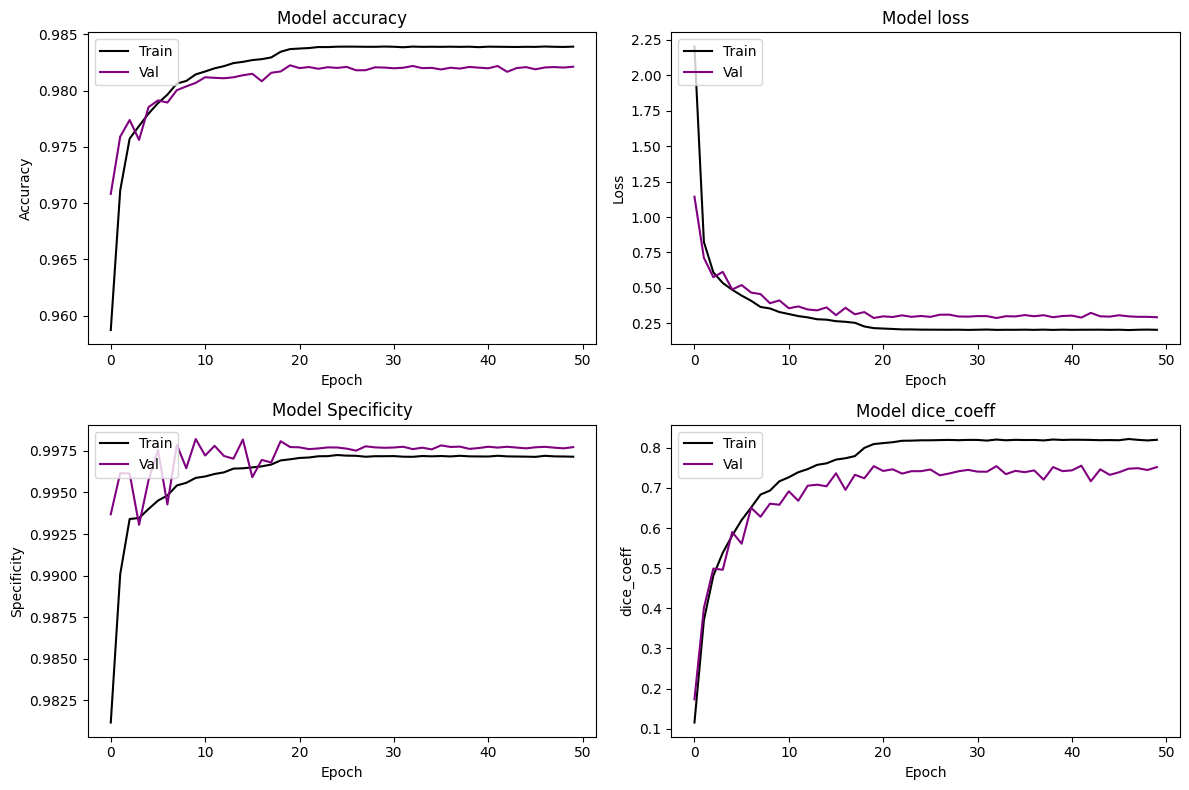

In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(hist.history['accuracy'], color='black')
plt.plot(hist.history['val_accuracy'], color='purple')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.subplot(2, 2, 2)
plt.plot(hist.history['loss'], color='black')
plt.plot(hist.history['val_loss'], color='purple')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.subplot(2, 2, 3)
plt.plot(hist.history['specificity'], color='black')
plt.plot(hist.history['val_specificity'], color='purple')
plt.title('Model Specificity')
plt.ylabel('Specificity')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.subplot(2, 2, 4)
plt.plot(hist.history['dice_coeff'], color='black')
plt.plot(hist.history['val_dice_coeff'], color='purple')
plt.title('Model dice_coeff')
plt.ylabel('dice_coeff')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.tight_layout()
plt.show()